**Introduction**


---


To run the notebook in Colab (recommended to use GPU/TPU for faster processing), follow these steps:

1. Set up Colab Environment:

  *  Open the notebook in Google Colab.
Ensure you are using a runtime with GPU or TPU enabled for optimal performance.


2. Run the Notebook:

  *  Execute the cells in the notebook sequentially to ensure all steps are followed correctly.
---

***Note:***

* Avoid running the block titled "Tested Other Models - (Sample Of The Most Informative Tests)."

The notebook includes the results of these tests along with detailed explanations of the choices and outcomes.

To avoid long runtime, you can skip this block.

## Installing required libraries

First let's install all the needed libraries.

In [1]:
!pip install Pillow numpy matplotlib tensorflow scikit-learn pandas seaborn keras visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 10.4 MB/s eta 0:00:00


## Data Preparation

### Downloading Images

Now let's load all the images so we can use them

In [2]:
# Clone the GitHub repository
!git clone https://github.com/NatiIPImages/MRIImages.git

Cloning into 'MRIImages'...
remote: Enumerating objects: 6744, done.
remote: Total 6744 (delta 0), reused 0 (delta 0), pack-reused 6744
Receiving objects: 100% (6744/6744), 140.80 MiB | 27.55 MiB/s, done.
Updating files: 100% (7023/7023), done.


### Imports

In [3]:
import os
from PIL import Image

import numpy as np
import copy

### Helper Functions:


In [4]:
# Function to load images from a specific folder
def load_images_from_folder(folder, image_size=(150, 150)):

    images = []

    for filename in os.listdir(folder):

        img_path = os.path.join(folder, filename)

        if os.path.isfile(img_path):

            img = Image.open(img_path)
            img = img.resize(image_size)

            images.append(img)

    return images

In [5]:
# Function to check if an image is truly a grayscale image.
def is_grey_scale(img):

    img = img.convert('RGB')

    w, h = img.size

    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b:
                return False
    return True

### Loading Images

Initialization

In [6]:
# Define the base path to the images
base_path = '/content/MRIImages/MRIImages'

# Define subdirectories for datasets
datasets = ['Testing', 'Validation', 'Training']
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Initialize a dictionary to hold images for each category and dataset
image_data = {dataset: {category: [] for category in categories} for dataset in datasets}

Loading the images

In [7]:
# Load images into the dictionary
for dataset in datasets:
  for category in categories:
      folder_path = os.path.join(base_path, dataset, category)
      image_data[dataset][category] = load_images_from_folder(folder_path)

Validation

1. Removing none gray scale images.
2. The amount of images for each category.

In [8]:

TotalImages = {dataset: {category: 0 for category in categories} for dataset in datasets}
image_count = 0


# Removing none gray scale images.
temp_image_data = copy.deepcopy(image_data)

for dataset in datasets:
  for category in categories:
    for image in image_data[dataset][category]:

      if not is_grey_scale(image):
        temp_image_data[dataset][category].remove(image)

image_data = temp_image_data


# Verify the loaded images
for dataset in datasets:
  for category in categories:
    TotalImages[dataset][category] = len(image_data[dataset][category])
    image_count += len(image_data[dataset][category])


print('Loaded', image_count)

Loaded 6903


Converting Images To GrayScale

In [9]:
temp_image_data = {dataset: {category: [] for category in categories} for dataset in datasets}

# Coverting to grayscale.
for dataset in datasets:
  for category in categories:
    for image in image_data[dataset][category]:
        temp_image_data[dataset][category].append(image.convert('L'))

image_data = temp_image_data

## Data Analysis

### Imports

In [10]:
import matplotlib.pyplot as plt

### Visualizations

#### Sample Image

Let's first see one of the images so we know what we work with.

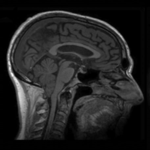

In [11]:
image_data['Training']['notumor'][0]

#### Data Distribution

##### Total

To get a feel of the data we have, let's plot some pie charts to understand its distribution

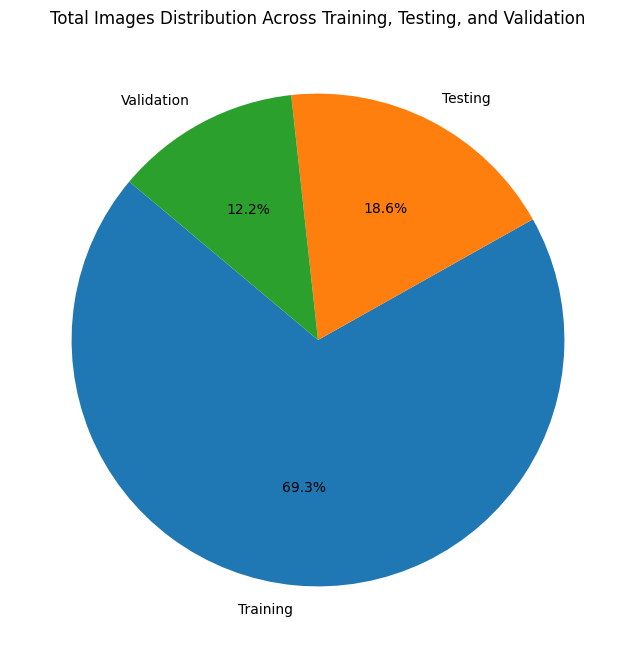

In [12]:
# Sum up the total number of images for each set
total_training = sum(TotalImages['Training'].values())
total_testing = sum(TotalImages['Testing'].values())
total_validation = sum(TotalImages['Validation'].values())

# Data for the pie chart
total_images_distribution = {'Training': total_training, 'Testing': total_testing, 'Validation': total_validation}

# Create pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(total_images_distribution.values(), labels=total_images_distribution.keys(), autopct='%1.1f%%', startangle=140)
ax.set_title('Total Images Distribution Across Training, Testing, and Validation')

# Display the plot
plt.show()

##### Each Group ( Train / Test / Validation )

Now let's see the total images in each dataset and category

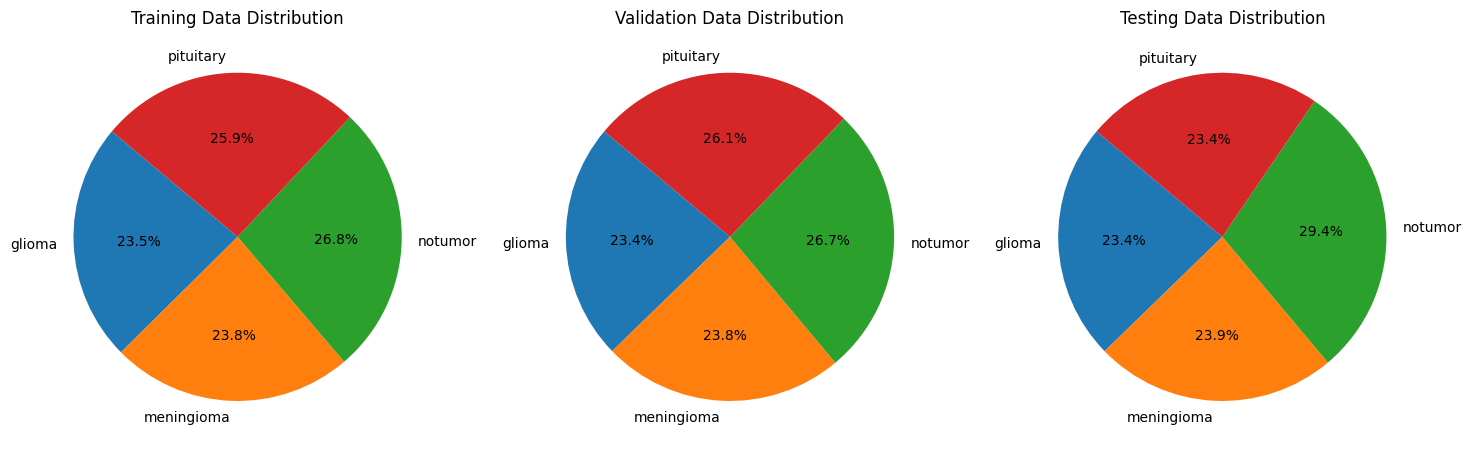

In [13]:
# Extract data for pie charts
training_data = TotalImages['Training']
testing_data = TotalImages['Testing']
validation_data = TotalImages['Validation']

# Create pie charts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Training Pie Chart
axs[0].pie(training_data.values(), labels=training_data.keys(), autopct='%1.1f%%', startangle=140)
axs[0].set_title('Training Data Distribution')

# Validation Pie Chart
axs[1].pie(validation_data.values(), labels=validation_data.keys(), autopct='%1.1f%%', startangle=140)
axs[1].set_title('Validation Data Distribution')

# Testing Pie Chart
axs[2].pie(testing_data.values(), labels=testing_data.keys(), autopct='%1.1f%%', startangle=140)
axs[2].set_title('Testing Data Distribution')

# Display the plots
plt.show()

We can see that our distribution is good and the data is balanced. This is critical for optimal model learning.

## Data Processing

### Imports

In [14]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Loading DataSets ( Train / Validation / Test )

Now let's split the loaded images to datasets & label them.

#### General Settings

In [15]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

SEED = 111

#### Loading DataSets

In [16]:
# Prepare train images.
train_images = []
train_labels = []

for label, images in image_data["Training"].items():
    for image in images:
        train_images.append(image)
        train_labels.append(label)

train_images = np.expand_dims(np.array(train_images), axis=-1)


# Prepare validation images.
validation_images = []
validation_labels = []

for label, images in image_data["Validation"].items():
    for image in images:
        validation_images.append(image)
        validation_labels.append(label)

validation_images = np.expand_dims(np.array(validation_images), axis=-1)


# Prepare test images.
test_images = []
test_labels = []

for label, images in image_data["Testing"].items():
    for image in images:
        test_images.append(image)
        test_labels.append(label)

test_images = np.expand_dims(np.array(test_images), axis=-1)

#### One-Hot Encoding

In [17]:
# One-hot encode the labels.
label_binarizer = LabelBinarizer()
label_binarizer.fit(categories)


# Vectorization of datasets.
train_labels_vectorized = label_binarizer.transform(train_labels)
validation_labels_vectorized = label_binarizer.transform(validation_labels)
test_labels_vectorized = label_binarizer.transform(test_labels)

In [18]:
#------ DEBUG ------#

# Get the class labels
class_labels = label_binarizer.classes_
print(f"Class Labels:\n{class_labels}\n")

# Mapping between one-hot vectors and original class labels
one_hot_to_label_mapping = {tuple(label_binarizer.transform([label])[0]): label for label in class_labels}
print("One-hot to Label Mapping:")
for vector, label in one_hot_to_label_mapping.items():
    print(f"Vector: {vector}, Label: {label}")

Class Labels:
['glioma' 'meningioma' 'notumor' 'pituitary']

One-hot to Label Mapping:
Vector: (1, 0, 0, 0), Label: glioma
Vector: (0, 1, 0, 0), Label: meningioma
Vector: (0, 0, 1, 0), Label: notumor
Vector: (0, 0, 0, 1), Label: pituitary


### Augmentation

To enhance the capabilities of our model, we will apply data augmentation to the training dataset.

#### Augmentation Settings ( Train Only )

In [19]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rotation_range = 10,
                                   brightness_range = (0.85, 1.15),
                                   width_shift_range = 0.002,
                                   height_shift_range = 0.002,
                                   shear_range = 12.5,
                                   zoom_range = 0,
                                   horizontal_flip = True,
                                   vertical_flip = False,
                                   fill_mode = "nearest")

# Create the generator
train_generator = train_datagen.flow(
    x = train_images,
    y = train_labels_vectorized,
    batch_size = batch_size,
    shuffle = True,
    seed = SEED)

#### Helper Functions

In [20]:
# Function to viusalize the augmented images.
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):

    # Generate augmented samples
    augmented_samples = train_generator.next()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    plt.show()

#### Visualization

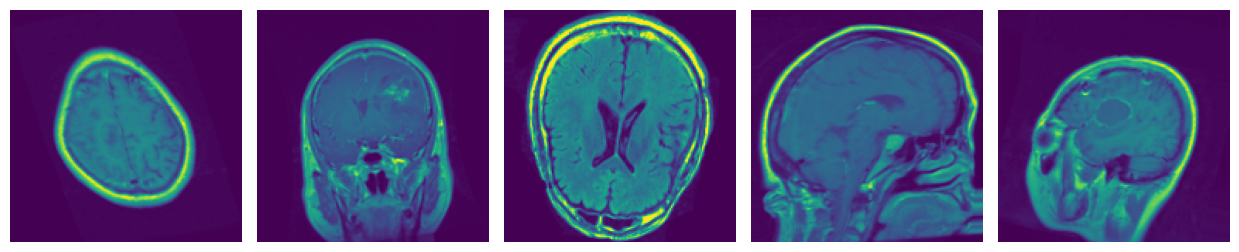

In [21]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8))

## Model

### Imports

In [40]:
# Model building
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, AveragePooling2D

# Visualize model
from visualkeras import layered_view

# Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting history graph
import matplotlib.pyplot as plt

### Settings

In [41]:
# Image shape: height, width, channels ( 1 - grayscale )
image_shape = train_images[0].shape

# Training epochs
epochs = 50

# Alpha
learning_rate = 0.001

### Define Model

In [42]:
# Define the model architecture
model = models.Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape, name="cv2d_layer_1"))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model.add(Conv2D(64, (4, 4), activation="relu", name="cv2d_layer_2"))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model.add(Conv2D(128, (4, 4), activation="relu", name="cv2d_layer_3"))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model.add(Conv2D(128, (4, 4), activation="relu", name="cv2d_layer_4"))
model.add(Flatten())

# Full connect layers
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed=SEED))
model.add(Dense(len(categories), activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cv2d_layer_1 (Conv2D)       (None, 147, 147, 32)      544       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 cv2d_layer_2 (Conv2D)       (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 cv2d_layer_3 (Conv2D)       (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 128)        

### Visualize Model

To better understand the model, let's see what it looks like.

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


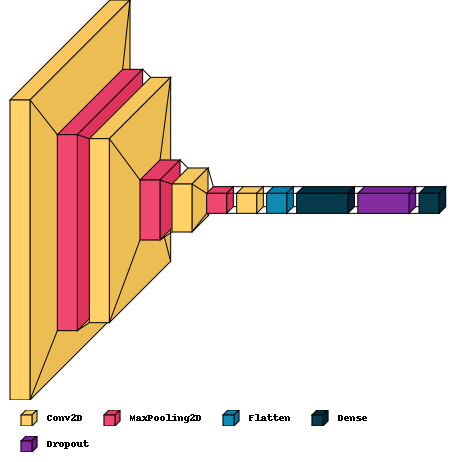

In [43]:
layered_view(model, legend=True, max_xy=300)

### Compile & Train

In [44]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate = learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')


# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=(validation_images, validation_labels_vectorized),
    callbacks=[checkpoint, early_stopping])

Epoch 1/50
150/150 [==============================] - 14s 76ms/step - loss: 1.0877 - accuracy: 0.5923 - val_loss: 0.7099 - val_accuracy: 0.6782


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
150/150 [==============================] - 12s 81ms/step - loss: 0.6126 - accuracy: 0.7396 - val_loss: 0.5691 - val_accuracy: 0.7878
Epoch 3/50
150/150 [==============================] - 12s 81ms/step - loss: 0.4966 - accuracy: 0.7982 - val_loss: 0.4989 - val_accuracy: 0.8510
Epoch 4/50
150/150 [==============================] - 13s 85ms/step - loss: 0.4196 - accuracy: 0.8406 - val_loss: 0.3701 - val_accuracy: 0.8844
Epoch 5/50
150/150 [==============================] - 13s 87ms/step - loss: 0.3888 - accuracy: 0.8521 - val_loss: 0.2604 - val_accuracy: 0.9309
Epoch 6/50
150/150 [==============================] - 12s 78ms/step - loss: 0.3243 - accuracy: 0.8676 - val_loss: 0.2853 - val_accuracy: 0.9130
Epoch 7/50
150/150 [==============================] - 12s 77ms/step - loss: 0.3008 - accuracy: 0.8822 - val_loss: 0.2349 - val_accuracy: 0.9261
Epoch 8/50
150/150 [==============================] - 11s 72ms/step - loss: 0.2618 - accuracy: 0.9015 - val_loss: 0.3801 - val_accuracy:

### Evaluation

Based on numerous tests, we can conclude that this model performs exceptionally well in classification, yielding results with 95-99% accuracy depending on the run.

#### Basic Evaluation

In [53]:
# Evaluate the model on the validation data
validation_loss, validation_accuracy = model.evaluate(validation_images, validation_labels_vectorized)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

27/27 [==============================] - 0s 6ms/step - loss: 0.1904 - accuracy: 0.9678
Validation Loss: 0.19043190777301788
Validation Accuracy: 0.9678188562393188


#### History Graph

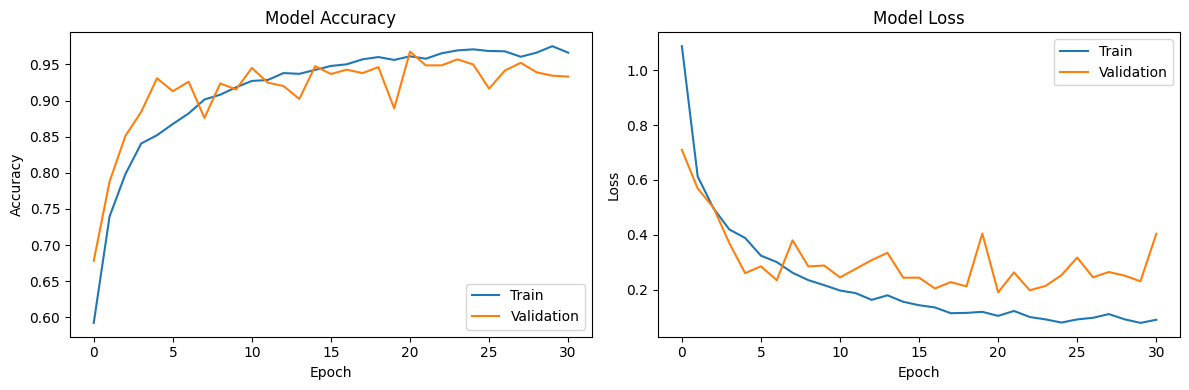

In [46]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])


plt.tight_layout()
plt.show()

## Tested Other Models - ( Sample Of The Most Informative Tests )

### Model 1 - More Filters

Test Conclusion:<br>Adding filters yields close to the same result. We will not use this approach due to increased training time without additional benefits.

Model Accuracy: 95-99%

#### Define Model

In [ ]:
# Define the model architecture
test_model = models.Sequential()

# Convolutional layer 1
test_model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
test_model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
test_model.add(Conv2D(64, (4, 4), activation="relu"))
test_model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
test_model.add(Conv2D(128, (4, 4), activation="relu"))
test_model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
test_model.add(Conv2D(256, (4, 4), activation="relu"))
test_model.add(Flatten())

# Full connect layers
test_model.add(Dense(512, activation="relu"))
test_model.add(Dropout(0.5, seed=SEED))
test_model.add(Dense(len(categories), activation="softmax"))

test_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 147, 147, 32)      544       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 4, 4, 128)        

#### Compile & Train

In [ ]:
# Compile the test_model
test_model.compile(
    optimizer=Adam(learning_rate = learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')


# Train the test_model
history = test_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=(validation_images, validation_labels_vectorized),
    callbacks=[checkpoint, early_stopping])

Epoch 1/50
150/150 [==============================] - 16s 96ms/step - loss: 1.3535 - accuracy: 0.6122 - val_loss: 0.6730 - val_accuracy: 0.6889
Epoch 2/50
150/150 [==============================] - 14s 95ms/step - loss: 0.5664 - accuracy: 0.7695 - val_loss: 0.3952 - val_accuracy: 0.8546
Epoch 3/50
150/150 [==============================] - 14s 95ms/step - loss: 0.4543 - accuracy: 0.8166 - val_loss: 0.3547 - val_accuracy: 0.8868
Epoch 4/50
150/150 [==============================] - 15s 96ms/step - loss: 0.3755 - accuracy: 0.8643 - val_loss: 0.3352 - val_accuracy: 0.8844
Epoch 5/50
150/150 [==============================] - 14s 96ms/step - loss: 0.3266 - accuracy: 0.8716 - val_loss: 0.2934 - val_accuracy: 0.9297
Epoch 6/50
150/150 [==============================] - 14s 95ms/step - loss: 0.3018 - accuracy: 0.8898 - val_loss: 0.2921 - val_accuracy: 0.9094
Epoch 7/50
150/150 [==============================] - 14s 95ms/step - loss: 0.2314 - accuracy: 0.9124 - val_loss: 0.2579 - val_accuracy:

#### Evaluation

##### Basic Evaluation

In [ ]:
# Evaluate the test_model on the validation data
validation_loss, validation_accuracy = test_model.evaluate(validation_images, validation_labels_vectorized)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

27/27 [==============================] - 1s 27ms/step - loss: 0.1740 - accuracy: 0.9499
Validation Loss: 0.1739666610956192
Validation Accuracy: 0.9499403834342957


##### History Graph

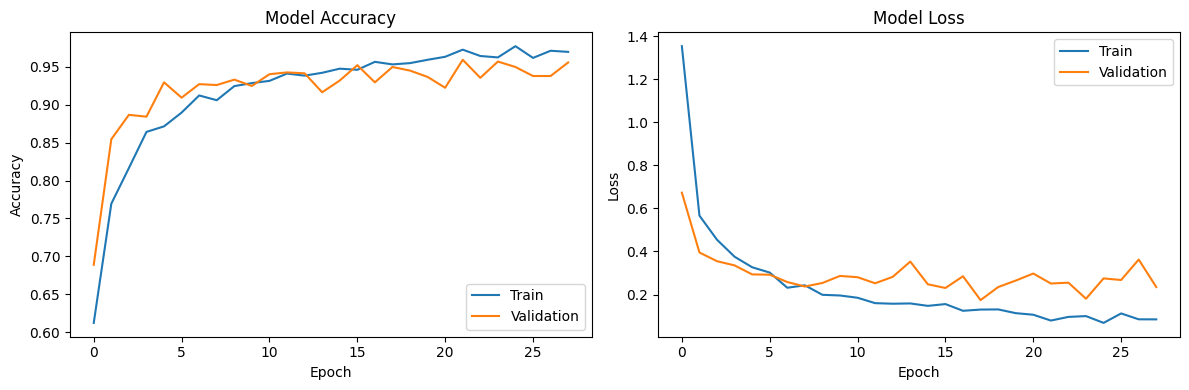

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])


plt.tight_layout()
plt.show()

### Model 2 - Classification Activation Function RelU -> Sigmoid

Test Conclusion:<br>Changing the activation function from RelU to Sigmoid in the classification layers greatly decreased the accuracy of the model.


Model Accuracy: 25% ~

#### Define Model

In [ ]:
# Define the model architecture
test_model = models.Sequential()

# Convolutional layer 1
test_model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
test_model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
test_model.add(Conv2D(64, (4, 4), activation="relu"))
test_model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
test_model.add(Conv2D(128, (4, 4), activation="relu"))
test_model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
test_model.add(Conv2D(128, (4, 4), activation="relu"))
test_model.add(Flatten())

# Full connect layers
test_model.add(Dense(512, activation="sigmoid"))
test_model.add(Dropout(0.5, seed=SEED))
test_model.add(Dense(len(categories), activation="softmax"))

test_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      544       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 128)        

#### Compile & Train

In [ ]:
# Compile the test_model
test_model.compile(
    optimizer=Adam(learning_rate = learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')


# Train the test_model
history = test_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=(validation_images, validation_labels_vectorized),
    callbacks=[checkpoint, early_stopping])

Epoch 1/50
150/150 [==============================] - 16s 99ms/step - loss: 1.6722 - accuracy: 0.2577 - val_loss: 1.4044 - val_accuracy: 0.2336
Epoch 2/50
150/150 [==============================] - 15s 98ms/step - loss: 1.5750 - accuracy: 0.2424 - val_loss: 1.3874 - val_accuracy: 0.2896
Epoch 3/50
150/150 [==============================] - 15s 99ms/step - loss: 1.5372 - accuracy: 0.2629 - val_loss: 1.3851 - val_accuracy: 0.2670
Epoch 4/50
150/150 [==============================] - 15s 98ms/step - loss: 1.4744 - accuracy: 0.2545 - val_loss: 1.3957 - val_accuracy: 0.2670
Epoch 5/50
150/150 [==============================] - 15s 98ms/step - loss: 1.4431 - accuracy: 0.2554 - val_loss: 1.3881 - val_accuracy: 0.2670
Epoch 6/50
150/150 [==============================] - 15s 97ms/step - loss: 1.4317 - accuracy: 0.2577 - val_loss: 1.4220 - val_accuracy: 0.2336
Epoch 7/50
150/150 [==============================] - 14s 96ms/step - loss: 1.4235 - accuracy: 0.2533 - val_loss: 1.3912 - val_accuracy:

#### Evaluation

##### Basic Evaluation

In [ ]:
# Evaluate the test_model on the validation data
validation_loss, validation_accuracy = test_model.evaluate(validation_images, validation_labels_vectorized)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

27/27 [==============================] - 1s 27ms/step - loss: 1.3851 - accuracy: 0.2670
Validation Loss: 1.3850804567337036
Validation Accuracy: 0.2669844925403595


##### History Graph

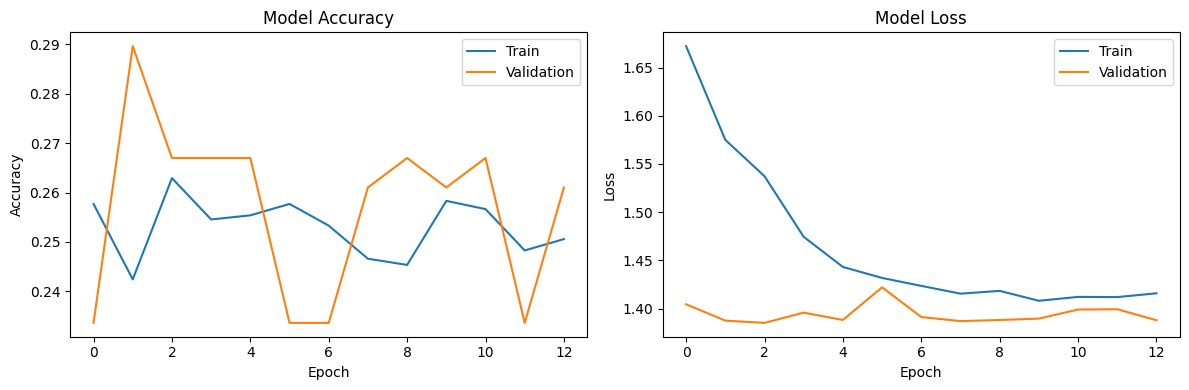

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])


plt.tight_layout()
plt.show()

### Model 3 - Filter & Pooling Size

Test Conclusion:<br>Changing the pooling sizes to 2x2 and changing the first filter size from 4x4 to 5x5, and all other filters from 4x4 to 3x3, caused a decrease in the accuracy of the model.




Model Accuracy: 88-94%

#### Define Model

In [ ]:
# Define the model architecture
test_model = models.Sequential()

# Convolutional layer 1
test_model.add(Conv2D(32, (5, 5), activation="relu", input_shape=image_shape))
test_model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 2
test_model.add(Conv2D(64, (3, 3), activation="relu"))
test_model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 3
test_model.add(Conv2D(128, (3, 3), activation="relu"))
test_model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 4
test_model.add(Conv2D(128, (3, 3), activation="relu"))
test_model.add(Flatten())

# Full connect layers
test_model.add(Dense(512, activation="relu"))
test_model.add(Dropout(0.5, seed=SEED))
test_model.add(Dense(len(categories), activation="softmax"))

test_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 146, 146, 32)      832       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 73, 73, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 35, 35, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 33, 33, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 16, 16, 128)      

#### Compile & Train

In [ ]:
# Compile the test_model
test_model.compile(
    optimizer=Adam(learning_rate = learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')


# Train the test_model
history = test_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=(validation_images, validation_labels_vectorized),
    callbacks=[checkpoint, early_stopping])

Epoch 1/50
150/150 [==============================] - 32s 203ms/step - loss: 2.7547 - accuracy: 0.5018 - val_loss: 0.9166 - val_accuracy: 0.6246
Epoch 2/50
150/150 [==============================] - 31s 203ms/step - loss: 0.8427 - accuracy: 0.6674 - val_loss: 0.5665 - val_accuracy: 0.8033
Epoch 3/50
150/150 [==============================] - 30s 199ms/step - loss: 0.6453 - accuracy: 0.7574 - val_loss: 0.4011 - val_accuracy: 0.8927
Epoch 4/50
150/150 [==============================] - 30s 201ms/step - loss: 0.5368 - accuracy: 0.8015 - val_loss: 0.3527 - val_accuracy: 0.8820
Epoch 5/50
150/150 [==============================] - 31s 203ms/step - loss: 0.4598 - accuracy: 0.8226 - val_loss: 0.2997 - val_accuracy: 0.9213
Epoch 6/50
150/150 [==============================] - 31s 208ms/step - loss: 0.4164 - accuracy: 0.8371 - val_loss: 0.2802 - val_accuracy: 0.9154
Epoch 7/50
150/150 [==============================] - 30s 202ms/step - loss: 0.4042 - accuracy: 0.8448 - val_loss: 0.3252 - val_ac

#### Evaluation

##### Basic Evaluation

In [ ]:
# Evaluate the test_model on the validation data
validation_loss, validation_accuracy = test_model.evaluate(validation_images, validation_labels_vectorized)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

27/27 [==============================] - 1s 42ms/step - loss: 0.2378 - accuracy: 0.9392
Validation Loss: 0.23775148391723633
Validation Accuracy: 0.9392133355140686


##### History Graph

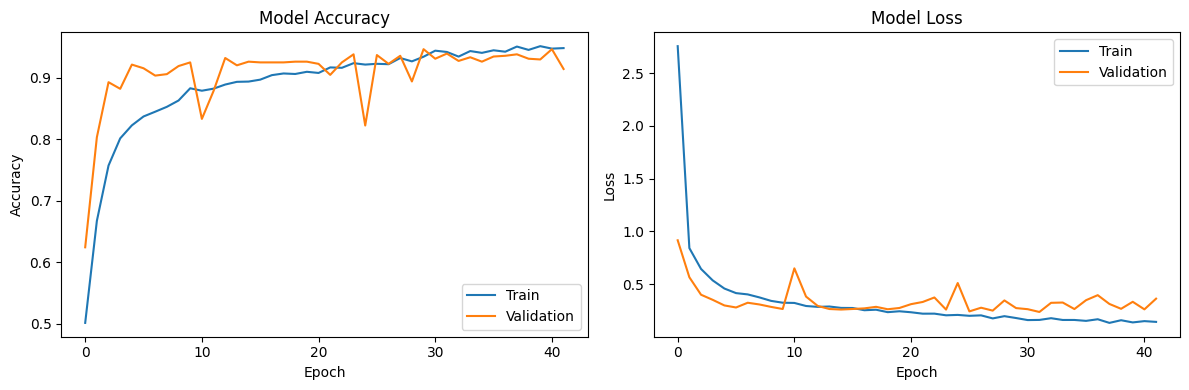

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])


plt.tight_layout()
plt.show()

### Model 4 - Pooling Method MaxPooling2D -> MeanPooling2D

Test Conclusion:<br>Changing the pooling method from max pooling to mean pooling, caused a slight decrease in the accuracy of the model.


Model Accuracy: 92-96%

#### Define Model

In [ ]:
# Define the model architecture
test_model = models.Sequential()

# Convolutional layer 1
test_model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
test_model.add(AveragePooling2D(pool_size=(3, 3)))

# Convolutional layer 2
test_model.add(Conv2D(64, (4, 4), activation="relu"))
test_model.add(AveragePooling2D(pool_size=(3, 3)))

# Convolutional layer 3
test_model.add(Conv2D(128, (4, 4), activation="relu"))
test_model.add(AveragePooling2D(pool_size=(3, 3)))

# Convolutional layer 4
test_model.add(Conv2D(128, (4, 4), activation="relu"))
test_model.add(Flatten())

# Full connect layers
test_model.add(Dense(512, activation="relu"))
test_model.add(Dropout(0.5, seed=SEED))
test_model.add(Dense(len(categories), activation="softmax"))

test_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 147, 147, 32)      544       
                                                                 
 average_pooling2d (Average  (None, 49, 49, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_25 (Conv2D)          (None, 46, 46, 64)        32832     
                                                                 
 average_pooling2d_1 (Avera  (None, 15, 15, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_26 (Conv2D)          (None, 12, 12, 128)       131200    
                                                                 
 average_pooling2d_2 (Avera  (None, 4, 4, 128)        

#### Compile & Train

In [ ]:
# Compile the test_model
test_model.compile(
    optimizer=Adam(learning_rate = learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')


# Train the test_model
history = test_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=(validation_images, validation_labels_vectorized),
    callbacks=[checkpoint, early_stopping])

Epoch 1/50
150/150 [==============================] - 23s 142ms/step - loss: 0.9430 - accuracy: 0.6057 - val_loss: 0.6665 - val_accuracy: 0.7330
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 21s 140ms/step - loss: 0.5994 - accuracy: 0.7526 - val_loss: 0.4523 - val_accuracy: 0.8236
Epoch 3/50
150/150 [==============================] - 21s 141ms/step - loss: 0.4578 - accuracy: 0.8164 - val_loss: 0.3710 - val_accuracy: 0.8784
Epoch 4/50
150/150 [==============================] - 21s 141ms/step - loss: 0.3687 - accuracy: 0.8540 - val_loss: 0.3092 - val_accuracy: 0.8915
Epoch 5/50
150/150 [==============================] - 21s 140ms/step - loss: 0.3288 - accuracy: 0.8766 - val_loss: 0.2920 - val_accuracy: 0.9023
Epoch 6/50
150/150 [==============================] - 21s 139ms/step - loss: 0.2690 - accuracy: 0.8973 - val_loss: 0.2665 - val_accuracy: 0.9225
Epoch 7/50
150/150 [==============================] - 21s 139ms/step - loss: 0.2599 - accuracy: 0.9059 - val_loss: 0.2879 - val_accuracy: 0.9035
Epoch 8/50
150/150 [==============================] - 21s 139ms/step - loss: 0.2227 - accuracy: 0.9172 - val_loss: 0.4087 - val_accuracy: 0.8

#### Evaluation

##### Basic Evaluation

In [ ]:
# Evaluate the test_model on the validation data
validation_loss, validation_accuracy = test_model.evaluate(validation_images, validation_labels_vectorized)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

27/27 [==============================] - 1s 30ms/step - loss: 0.2157 - accuracy: 0.9356
Validation Loss: 0.2157040387392044
Validation Accuracy: 0.9356376528739929


##### History Graph

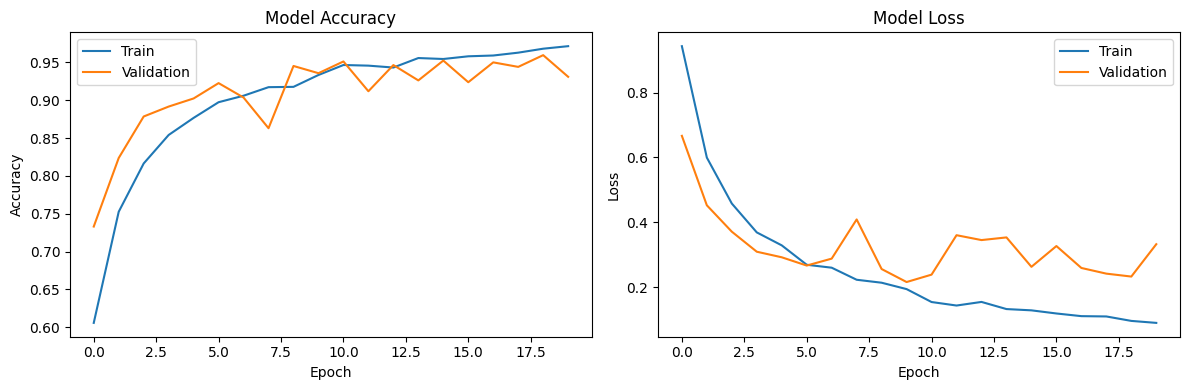

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])


plt.tight_layout()
plt.show()

### Model 5 - More Classification Layers

Test Conclusion:<br>Adding an additional classification layer yields close to the same result. We will not use this approach due to increased training time without additional benefits.

Model Accuracy: 95-99%

#### Define Model

In [ ]:
# Define the model architecture
test_model = models.Sequential()

# Convolutional layer 1
test_model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
test_model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
test_model.add(Conv2D(64, (4, 4), activation="relu"))
test_model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
test_model.add(Conv2D(128, (4, 4), activation="relu"))
test_model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
test_model.add(Conv2D(128, (4, 4), activation="relu"))
test_model.add(Flatten())

# Full connect layers
test_model.add(Dense(512, activation="relu"))
test_model.add(Dropout(0.5, seed=SEED))
test_model.add(Dense(1024, activation="relu"))
test_model.add(Dropout(0.5, seed=SEED))
test_model.add(Dense(len(categories), activation="softmax"))

test_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 147, 147, 32)      544       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 4, 4, 128)        

#### Compile & Train

In [ ]:
# Compile the test_model
test_model.compile(
    optimizer=Adam(learning_rate = learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')


# Train the test_model
history = test_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=(validation_images, validation_labels_vectorized),
    callbacks=[checkpoint, early_stopping])

Epoch 1/50
150/150 [==============================] - 16s 98ms/step - loss: 1.1458 - accuracy: 0.5369 - val_loss: 0.6215 - val_accuracy: 0.7259
Epoch 2/50
150/150 [==============================] - 15s 96ms/step - loss: 0.6645 - accuracy: 0.7088 - val_loss: 0.4730 - val_accuracy: 0.7783
Epoch 3/50
150/150 [==============================] - 15s 97ms/step - loss: 0.5337 - accuracy: 0.7810 - val_loss: 0.4062 - val_accuracy: 0.8582
Epoch 4/50
150/150 [==============================] - 15s 97ms/step - loss: 0.4648 - accuracy: 0.8149 - val_loss: 0.3424 - val_accuracy: 0.8844
Epoch 5/50
150/150 [==============================] - 14s 95ms/step - loss: 0.4270 - accuracy: 0.8293 - val_loss: 0.3956 - val_accuracy: 0.8844
Epoch 6/50
150/150 [==============================] - 14s 95ms/step - loss: 0.3952 - accuracy: 0.8521 - val_loss: 0.4174 - val_accuracy: 0.8284
Epoch 7/50
150/150 [==============================] - 14s 95ms/step - loss: 0.3649 - accuracy: 0.8603 - val_loss: 0.4007 - val_accuracy:

#### Evaluation

##### Basic Evaluation

In [ ]:
# Evaluate the test_model on the validation data
validation_loss, validation_accuracy = test_model.evaluate(validation_images, validation_labels_vectorized)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

27/27 [==============================] - 1s 27ms/step - loss: 0.2349 - accuracy: 0.9297
Validation Loss: 0.23490457236766815
Validation Accuracy: 0.929678201675415


##### History Graph

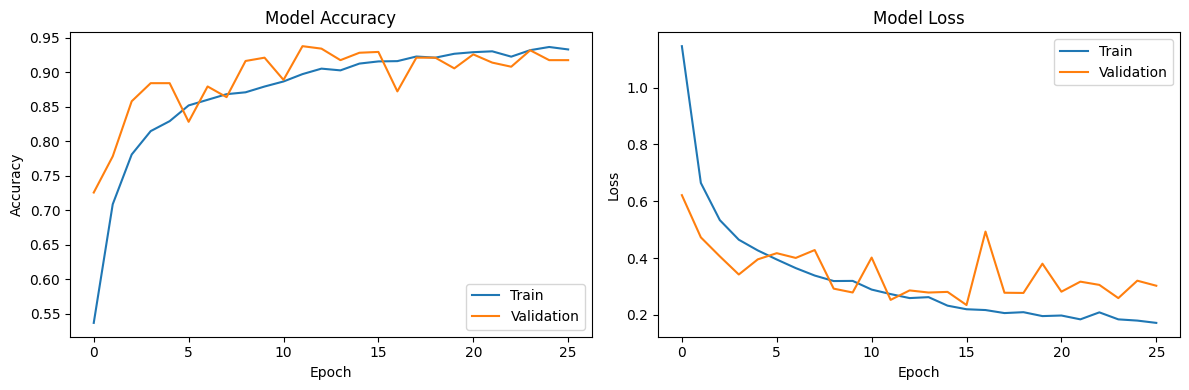

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])


plt.tight_layout()
plt.show()

## Visualizations

Through all the visualizations, we can clearly see that the model performs really well.

Pituitary and non-tumor images are classified correctly 98%+ of the time.

Meningioma and glioma have a high accuracy of 90%+.

* **Depending on the run, higher results could be achieved.**

### Model Prediction Calculation

In [49]:
# Predictions on test dataset
predictions = model.predict(test_images)
predicted_categories_index = np.argmax(predictions, axis=1)
predicted_categories = [categories[category_index] for category_index in predicted_categories_index]

41/41 [==============================] - 0s 9ms/step


### Confusion Matrix

#### Imports

In [50]:
from sklearn.metrics import confusion_matrix

import seaborn as sns

#### Calculation

In [51]:
# Calculating confusion matrix
confusion_matrix_array = confusion_matrix(test_labels, predicted_categories)

#### Visualization

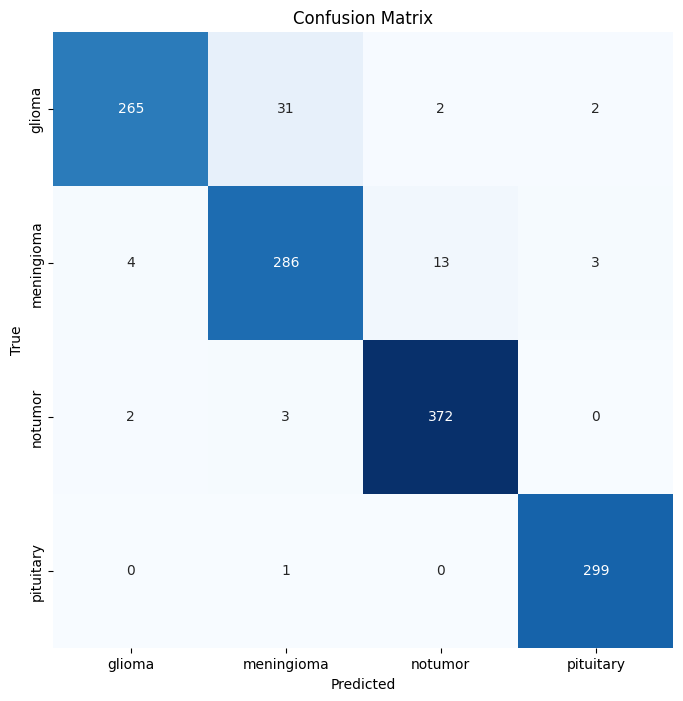

In [ ]:
# Plotting the matrix
plt.figure(figsize=(8,8))

sns.heatmap(confusion_matrix_array, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks = np.arange(len(categories)) + 0.5, labels = categories, ha = 'center')
plt.yticks(ticks = np.arange(len(categories)) + 0.5, labels = categories, va = 'center')
plt.show()

### Metrics ( Precision, Recall, F1-Score )

In [ ]:
# Calculating 4 different metrics
precision = np.diag(confusion_matrix_array) / np.sum(confusion_matrix_array, axis=0)
recall = np.diag(confusion_matrix_array) / np.sum(confusion_matrix_array, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
accuracy = np.sum(np.diag(confusion_matrix_array)) / np.sum(confusion_matrix_array)

# Printing the results based on each category
for i, category in enumerate(categories):
    print(f"Class: {category.title()}")
    print(f"Precision: {precision[i]:.3f}")
    print(f"Recall: {recall[i]:.3f}")
    print(f"F1-Score: {f1_score[i]:.3f}\n")

# Showing the total accuracy of the model
print(f"\nAccuracy: {accuracy:.3f}")

Class: Glioma
Precision: 0.978
Recall: 0.883
F1-Score: 0.928

Class: Meningioma
Precision: 0.891
Recall: 0.935
F1-Score: 0.912

Class: Notumor
Precision: 0.961
Recall: 0.987
F1-Score: 0.974

Class: Pituitary
Precision: 0.984
Recall: 0.997
F1-Score: 0.990


Accuracy: 0.952


### ROC

#### Imports

In [ ]:
from sklearn.metrics import roc_curve, auc

#### Calculation

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_vectorized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#### Plotting

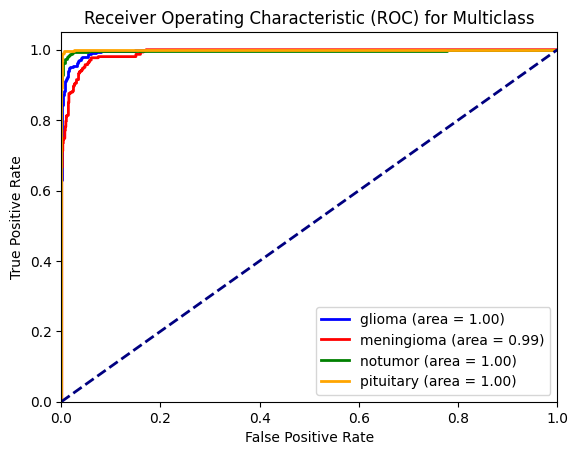

In [ ]:
# Plotting the ROC curve for each class
plt.figure()

colors = ['blue', 'red', 'green', 'orange']

for i in range(len(categories)):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2, label=f'{categories[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multiclass')
plt.legend(loc='lower right')
plt.show()


### Image True / Prediction Label Plot

#### Generate Random Sample

In [ ]:
# Randomly sample test images

sample_indices = np.random.choice(len(test_images), size=9, replace=False)
sample_images = test_images[sample_indices]
sample_predictions = [predicted_categories[i] for i in sample_indices]
sample_true_labels = [test_labels[i]          for i in sample_indices]

#### Visualization

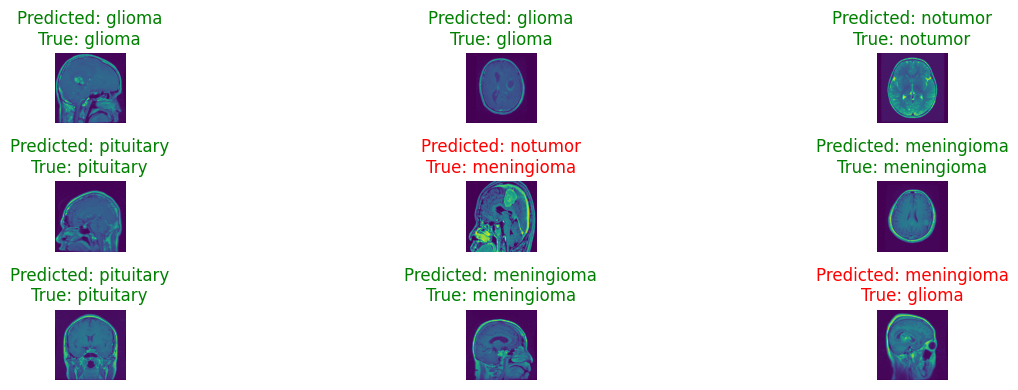

In [ ]:
# Plot sample images with their predicted and true labels
plt.figure(figsize=(15,4))

# Loop over samples
for i, image in enumerate(sample_images):
    # Form subplot and plot
    plt.subplot(3, 3, i + 1)

    plt.imshow(image)
    plt.axis("off")

    # Set axis label color depending on correct prediction or not
    prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)

plt.tight_layout()
plt.show()


## Grad-Cam Segmentation

Grad-CAM (Gradient-weighted Class Activation Mapping) helps us understand and visualize what parts of an image are most important for a neural network's decision-making process.

In this example of a meningioma tumor, we can clearly see that the model accurately highlights the tumor part. From this, we can recognize that the model comprehends the task.

### Imports

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import matplotlib as mpl
from PIL import Image

### Helper Functions

In [31]:
# Function to load an image and convert it to an array.
def get_img_array(img_path, size=(150, 150), grayscale=True):
    img = keras.utils.load_img(img_path, target_size=size, color_mode='grayscale' if grayscale else 'rgb')
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [32]:
# Function to generate a Grad-CAM heatmap.
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [33]:
# Function to save and display a Grad-CAM heatmap superimposed on the original image.
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, view=False):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    if view:
        display(Image.open(cam_path))

In [34]:
# Function to decode model predictions to class labels.
def decode_predictions(preds):
    classes = ['Glioma', 'meningioma', 'No Tumor', 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction

In [35]:
# Function to make a prediction and generate a Grad-CAM heatmap for an image.
def make_prediction(img_path, model, last_conv_layer_name, campath="cam.jpg", view=False):
    img_array = get_img_array(img_path, size=(150, 150), grayscale=True)
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap, cam_path=campath, view=view)
    return [campath, decode_predictions(preds)]

### Image Segmentation

1/1 [==============================] - 0s 19ms/step


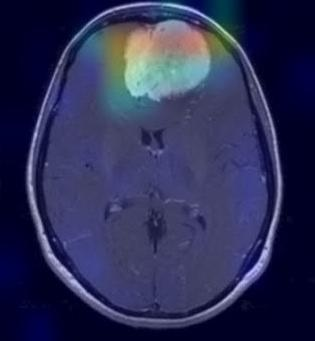

Prediction: meningioma
True label: meningioma


In [48]:
# Define the last convolutional layer name
last_conv_layer_name = "cv2d_layer_3"

# Example path to your image
img_path = "/content/MRIImages/MRIImages/Testing/meningioma/Te-me_0027.jpg"  # Image path



# Use the make_prediction function to generate the Grad-CAM heatmap and prediction
campath, prediction = make_prediction(img_path, model, last_conv_layer_name, campath="cam.jpg", view=True)

print(f"Prediction: {prediction}")
print(f"True label: {img_path.split('/')[-2]}")

# Showing the image
img = Image.open(campath)
img.show()